In [1]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  #!pip install equadratures # for standard pip install
  !pip install git+https://github.com/Effective-Quadratures/Effective-Quadratures.git@develop # for specific branch 

import numpy as np                                                                                                                                                                                      
import matplotlib.pyplot as plt
from equadratures import *
from equadratures import datasets

  Cloning https://github.com/Effective-Quadratures/Effective-Quadratures.git (to revision develop) to /tmp/pip-req-build-ghiohqe4
  Running command git clone -q https://github.com/Effective-Quadratures/Effective-Quadratures.git /tmp/pip-req-build-ghiohqe4
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Created wheel for equadratures: filename=equadratures-8.1.4-cp36-none-any.whl size=114152 sha256=dd75a3949eef5654320bbb5c97b6bb285a23cd02974593fc4cf2420fb009d022
  Stored in directory: /tmp/pip-ephem-wheel-cache-m8ixzqnv/wheels/84/ff/6c/08047ee3324a42baf7b49cc78cb0906b3ab32fa38135fa2ad5
Successfully built equadratures


## Introduction
This notebook tests new capability in `poly.get_polyfit()`, whereby setting `uq=True` means `get_polyfit()` returns the estimated uncertainty of the polynomial approximation.

More specifically, let $\boldsymbol{\Sigma}$ be the covariance matrix associated with the measurements. Then we can estimate the covariance in the polynomial coefficients, via $\boldsymbol{\Sigma}_{\boldsymbol{X}} = \boldsymbol{Q} \boldsymbol{\Sigma}  \boldsymbol{Q}^T,$ where $\boldsymbol{Q}$ is the pseudoinverse of the weighted orthogonal polynomial matrix $\boldsymbol{Q} = \left( \boldsymbol{A}^{T} \boldsymbol{A} \right)^{-1} \boldsymbol{A}^{T}$ where $\boldsymbol{A} = \boldsymbol{W}^{T} \boldsymbol{P}^{T}$. 

The covariance matrix $\boldsymbol{\Sigma}_{\boldsymbol{X}}$ is then propagated through to the polynomial's predictions at the points specified in `get_polyfit()`.  

## Test 1
Variance estimated from variance of training data (i.e. empirical variance)

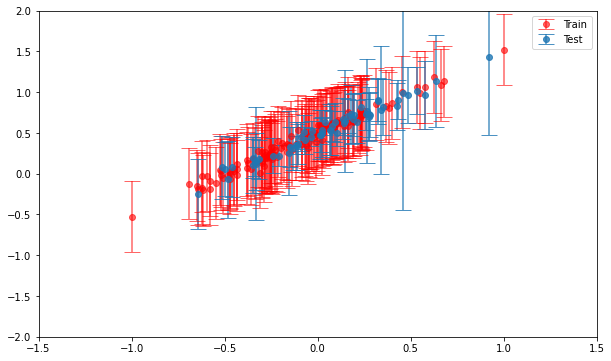

0.32776999799866485


In [3]:
dim = 3
n = 1
N = 200
data_noise = 0.05
X,y = datasets.gen_linear(n_observations=N,n_dim=dim,bias=0.5,n_relevent=1,noise=data_noise,random_seed=1)
X_train, X_test, y_train, y_test = datasets.train_test_split(X,y,train=0.7,random_seed=42)
N_train = X_train.shape[0]
N_test  = X_test.shape[0]

param = Parameter(distribution='Uniform', lower=-1, upper=1, order=n)
myParameters = [param for i in range(dim)] # one-line for loop for parameters
myBasis = Basis('tensor-grid')
poly = Poly(myParameters, myBasis, method='least-squares', sampling_args={'sample-points':X_train, 'sample-outputs':y_train.reshape(-1,1)} )
poly.set_model()
y_pred, y_std = poly.get_polyfit(X_test,uq=True)

# Plot!
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.errorbar(X_train[:,0], y_train, 1.96 * np.sqrt(data_noise), fmt='ro', ecolor='r', capthick=1, capsize=8,alpha=0.6,label='Train')
ax.errorbar(X_test[:,0], y_test, y_std, fmt='C0o', ecolor='C0', capthick=1, capsize=8,alpha=0.8,label='Test')
ax.axis('tight')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-2,2])
ax.legend()
plt.show()

print(y_std.mean())

## Test 2
Variance prescribed by user by the `'sample-output-variances':y_var` within `sampling_args`.

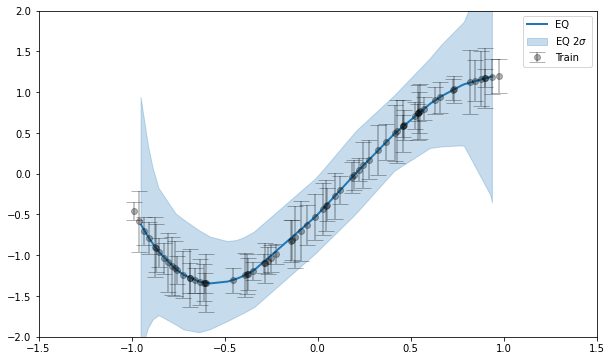

0.6820955736852787


In [4]:
dim = 1
n = 5
N = 100
data_noise = 0.0
state = np.random.RandomState(42)
our_function = lambda x:  0.3*x**4 -1.6*x**3 +0.6*x**2 +2.4*x - 0.5
X = state.uniform(-1,1,N)
y = our_function(X)
X_train, X_test, y_train, y_test = datasets.train_test_split(X,y,train=0.7,random_seed=42)
idx = np.argsort(X_test)
X_test = X_test[idx]
y_test = y_test[idx]
N_train = X_train.shape[0]
N_test  = X_test.shape[0]
y_var = state.uniform(0.05,0.2,N_train)**2

param = Parameter(distribution='Uniform', lower=-1, upper=1, order=n)
myParameters = [param for i in range(dim)] # one-line for loop for parameters
myBasis = Basis('univariate')
poly = Poly(myParameters, myBasis, method='least-squares', sampling_args={'sample-points':X_train.reshape(-1,1), 
                                                                          'sample-outputs':y_train.reshape(-1,1), 
                                                                          'sample-output-variances':y_var} )
poly.set_model()
y_pred, y_std = poly.get_polyfit(X_test,uq=True)
y_pred = y_pred.squeeze()
y_std = y_std.squeeze()

# Plot!
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.errorbar(X_train, y_train, 1.96 * np.sqrt(y_var), fmt='ko', ecolor='k', capthick=1, capsize=8,alpha=0.3,label='Train')
ax.plot(X_test,y_pred,'-C0',lw=2,label='EQ')
ax.fill_between(X_test, y_pred+y_std, y_pred-y_std, alpha=.25,color='C0',label='EQ 2$\sigma$')
ax.axis('tight')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-2,2])
ax.legend()
plt.show()

print(y_std.mean())